In [1]:
name ="min"

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 

In [3]:
df = pd.read_parquet(f"final_data/{name}/final_data.parquet")

In [4]:
#rename columns with - for _

df.columns = df.columns.str.replace('-','_')
df.drop(["recording_time","aircraftSerNum_1","start_date","end_date","soma_betinho","cumulative_hasfailed","hasfailed"], axis=1, inplace=True)


In [5]:
X = df.drop(["time_to_failure"], axis=1)
y = df["time_to_failure"]

In [6]:
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
model = GradientBoostingRegressor()
model.fit(X_train, y_train)


c:\Python311\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Python311\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Python311\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Python311\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Python311\Lib\site-pac

GradientBoostingRegressor()

['cumulative_duration', 'bleedMonPress_2b', 'bleedPrsovFbk_1a', 'bleedSwPress_2b', 'bleedPrsovFbk_1b', 'bleedMonPress_1b', 'bleedSwPress_1b', 'bleedMonPress_1a', 'bleedSwPress_1a', 'bleedFavTmFbk_2b', 'bleedMonPress_2a', 'bleedPrecoolDiffPress_1b', 'bleedPrecoolDiffPress_2b']


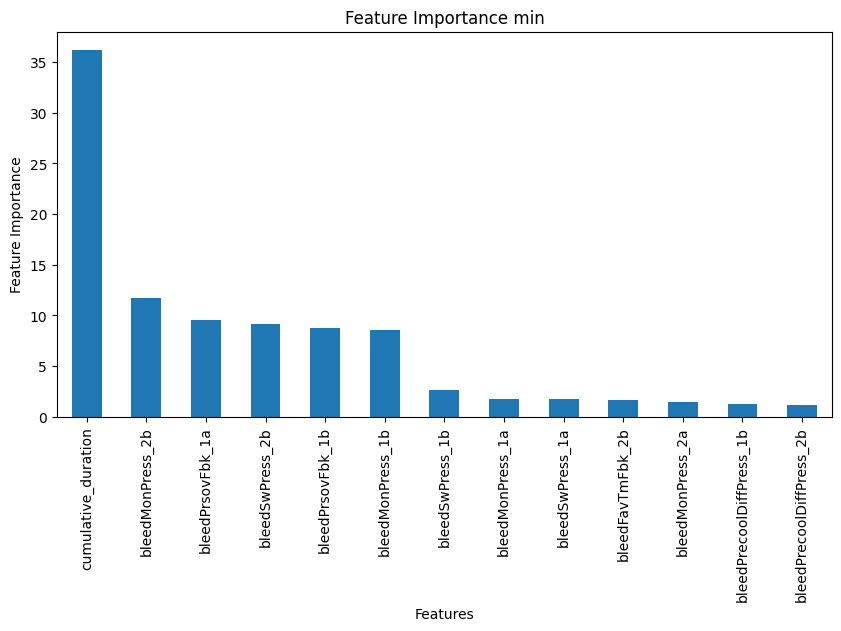

In [10]:
model.feature_importances_
#plot feature importance
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances = feat_importances.sort_values(ascending=False)*100
feat_importances = feat_importances[feat_importances> 1.0]
with open(f"./feature_selection/features_{name}.txt","w") as f:
    print(feat_importances.index.tolist())
    f.write(str(feat_importances.index.tolist()))
    f.close()
feat_importances.plot(kind="bar",title=f"Feature Importance {name}", figsize=(10,5), xlabel="Features", ylabel="Feature Importance")
plt.savefig(f"./feature_importances/feature_importance_{name}.png", dpi=300, bbox_inches='tight')
plt.show()

In [11]:
from sklearn.metrics import mean_absolute_error
y_pred = model.predict(X_test)
emr = mean_absolute_error(y_test, y_pred)
emr_train = mean_absolute_error(y_train, model.predict(X_train))
print(f"Erro médio absoluto: {emr}")
print(f"Erro médio absoluto (treino): {emr_train}")

Erro médio absoluto: 1188669.417200753
Erro médio absoluto (treino): 1170257.9120750763


c:\Python311\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Python311\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Python311\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Python311\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Python311\Lib\site-pac

In [57]:
import pickle
pickle.dump(model, open(f"./models_pickles/model_{name}.pkl", "wb"))


Configuração SageMaker

In [ ]:
import sagemaker
import boto3
from sagemaker import Session
import sagemaker.amazon.common as smac
import io
import os

In [ ]:
session = sagemaker.Session()
bucket = 'bleedrunner'
subpasta_dataset = '../betinho/agregated_data/standart_deviation.parquet'


In [ ]:
with open('../betinho/agregated_data/standart_deviation.parquet', 'rb') as f:
    boto3.Session().resource('s3').Bucket(bucket).Object(subpasta_dataset).upload_fileobj(f)

Treinamento do modelo

In [ ]:
from sagemaker import image_uris
container = image_uris.retrieve('xgboost', boto3.Session().region_name, '1.2-1')

In [ ]:
xgboost = sagemaker.estimator.Estimator(image_uris = container,
                                        role = sagemaker.get_execution_role(),
                                        instance_count = 1,
                                        instance_type = 'ml.m4.xlarge',
                                        output_path = 's3://{}/{}/output'.format(bucket, 'xgboost_model'),
                                        sagemaker_session = session)

In [ ]:
xgboost.set_hyperparameters(num_round = 100, objective = 'reg:squarederror', max_depth = 5, eta = 0.1, gamma = 4, min_child_weight = 6, subsample = 0.8, silent = 0, early_stopping_rounds = 10)

Deploy, previsões e avaliação

In [ ]:
xgboost_classifier = xgboost.deploy(initial_instance_count = 1, instance_type = 'ml.m4.xlarge')


In [ ]:
from sagemaker.serializers import CSVSerializer
xgboost_classifier.serializer = CSVSerializer()

In [ ]:
X_test.shape, type(X_test)

In [ ]:
previsoes = np.array(X_test.iloc[0,:]).reshape(1,-1)

In [ ]:
previsoes = (xgboost_classifier.predict(previsoes)).decode('utf-8')